# Data Understanding

Our data was sourced from

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers import RMSprop, Adam
from keras.models import Sequential
from keras.layers import Dense
from keras import models, layers
from keras.utils import plot_model
import numpy as np 
import pandas as pd
from PIL import Image
import glob
import os, os.path, shutil
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
from tensorflow.keras.utils import img_to_array, array_to_img, load_img
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
import seaborn as sns
import pydot
import random
from dask import bag,  diagnostics 

# Basic EDA
open first image and check size

In [2]:
im = Image.open('Dataset_Strawberry_Leaf_Disease/healthy/998.jpg')
arr = np.array(im)
arr.shape

(3840, 5120, 3)

In [3]:
# Directory with leaf_spot pictures
leafspot_dir = os.path.join('./Dataset_Strawberry_Leaf_Disease/leaf_spot')

# Directory with healthy pictures
healthy_dir = os.path.join('./Dataset_Strawberry_Leaf_Disease/healthy')

# Directory with Calciumdeficiency pictures
Calciumdeficiency_dir = os.path.join('./Dataset_Strawberry_Leaf_Disease/Calciumdeficiency')


In [4]:
train_leafspot_names = os.listdir(leafspot_dir)
no_leafspot = len(os.listdir(leafspot_dir))
print('Total leaf_spot Images:', len(os.listdir(leafspot_dir)))
print(train_leafspot_names[:5])
print('')

train_healthy_names = os.listdir(healthy_dir)
no_healthy = len(os.listdir(healthy_dir))
print('Total healthy Images:', len(os.listdir(healthy_dir)))
print(train_healthy_names[:5])
print('')

train_Calciumdeficiency_names = os.listdir(Calciumdeficiency_dir)
no_Calciumdeficiency = len(os.listdir(Calciumdeficiency_dir))
print('Total Calciumdeficiency Images:', len(os.listdir(Calciumdeficiency_dir)))
print(train_Calciumdeficiency_names[:5])

Total leaf_spot Images: 615
['leaf_spot1.jpg', 'leaf_spot10.jpg', 'leaf_spot100.jpg', 'leaf_spot101.jpg', 'leaf_spot102.jpg']

Total healthy Images: 626
['1003.jpg', '1004.jpg', '1007.jpg', '1014.jpg', '1016.jpg']

Total Calciumdeficiency Images: 805
['1.jpg', '10.jpg', '100.jpg', '1000.jpg', '1001.jpg']


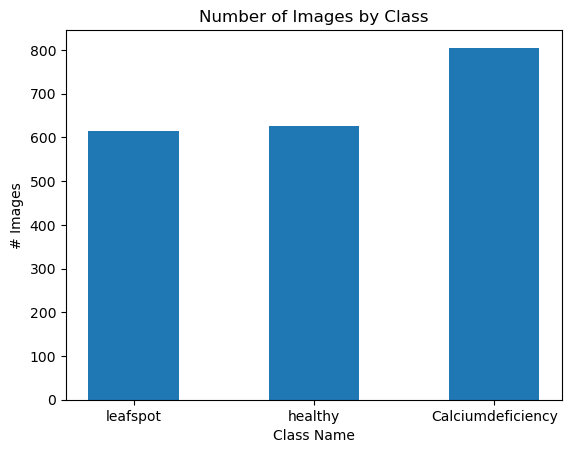

In [5]:
#plot number of classes to identify possible imbalances
number_classes = {
    'leafspot': 615,
    'healthy': 626,
    'Calciumdeficiency': 805,
}

plt.bar(number_classes.keys(), number_classes.values(), width = .5);
plt.title("Number of Images by Class");
plt.xlabel('Class Name');
plt.ylabel('# Images');

# View sample images of each class

In [6]:
# Show images displayed 5x5
nrows = 5
ncols = 5

# Index for iterating over images
pic_index = 0

pic_index += 400

next_leafspot_pix = [os.path.join(leafspot_dir, fname) 
                for fname in train_leafspot_names[pic_index-5:pic_index]]

next_healthy_pix = [os.path.join(healthy_dir, fname) 
                for fname in train_healthy_names[pic_index-5:pic_index]]

next_Calciumdeficiency_pix = [os.path.join(Calciumdeficiency_dir, fname) 
                for fname in train_Calciumdeficiency_names[pic_index-5:pic_index]]

def show_image_sample(pic_directory):
    
    '''Returns 4x2 image samples from given directory'''
    
    fig = plt.gcf()
    fig.set_size_inches(ncols * 5, nrows * 5)
    for i, img_path in enumerate(pic_directory):
        sp = plt.subplot(nrows, ncols, i + 1)
        sp.axis('Off')
        img = mpimg.imread(img_path)
        plt.imshow(img)
    plt.show()

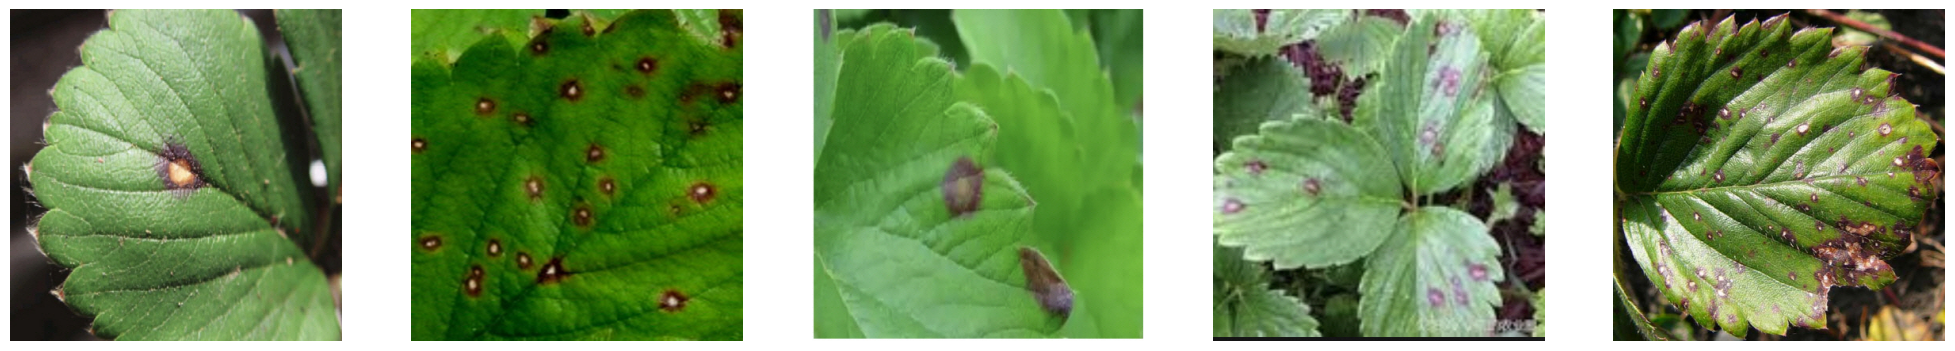

In [7]:
# Showing sample of leaf_spot images
show_image_sample(next_leafspot_pix)

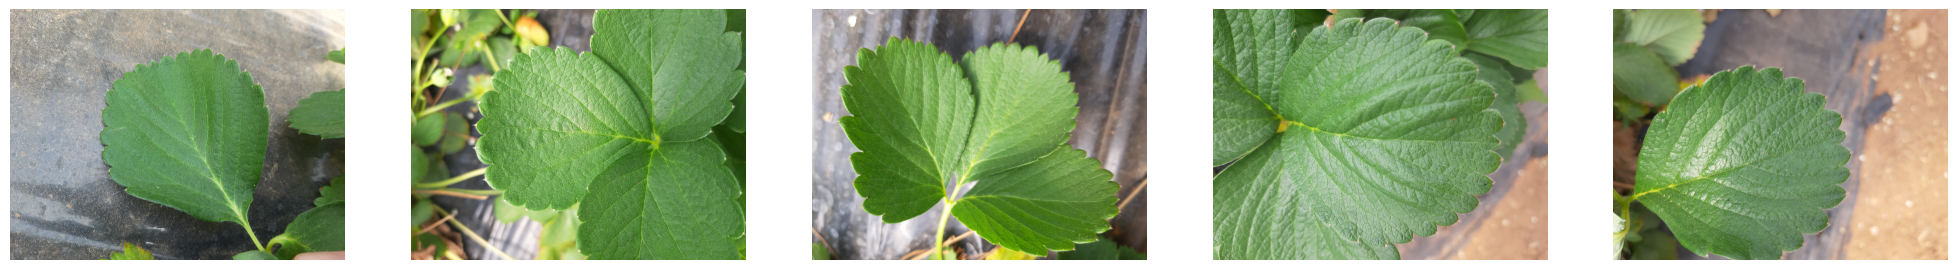

In [8]:
# Showing sample of healthy images
show_image_sample(next_healthy_pix)

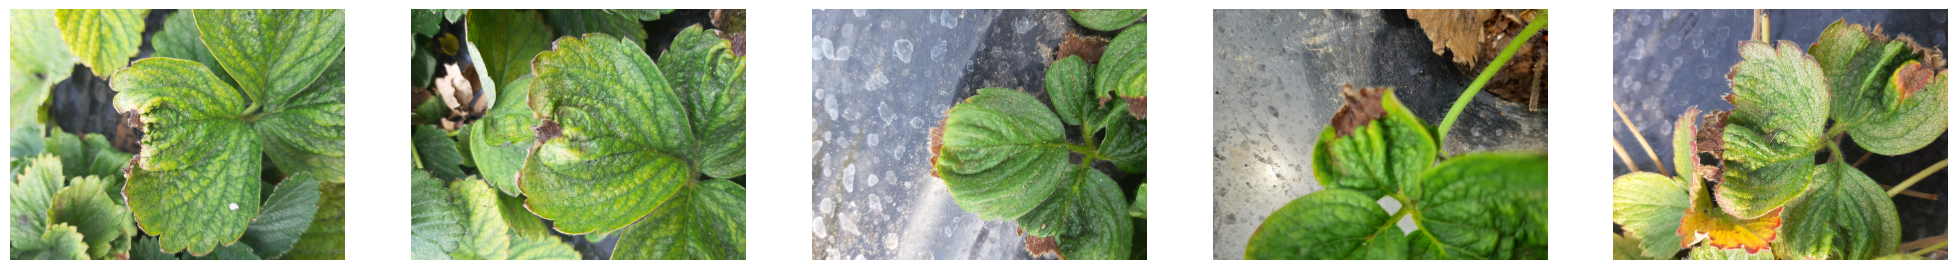

In [9]:
# Showing sample of Calciumdeficiency images
show_image_sample(next_Calciumdeficiency_pix)

# Visualize Image Size before Preprocessing/ Resizing

[########################################] | 100% Completed | 8.53 ss
[########################################] | 100% Completed | 131.93 s
[########################################] | 100% Completed | 112.95 s


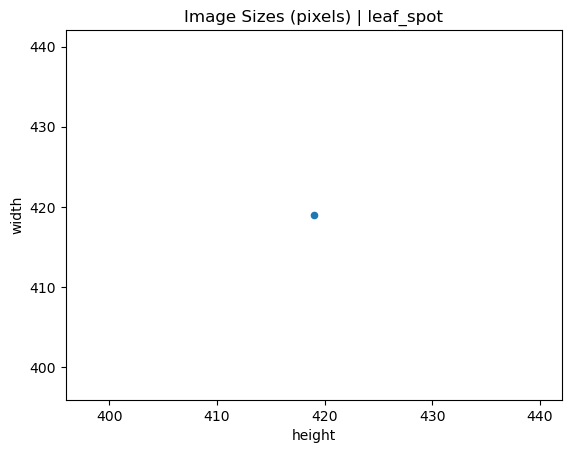

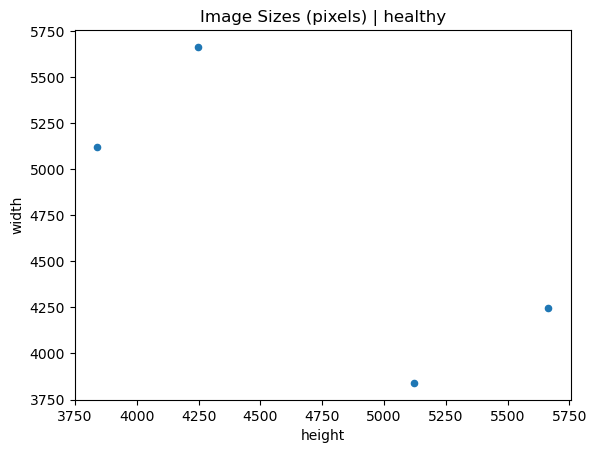

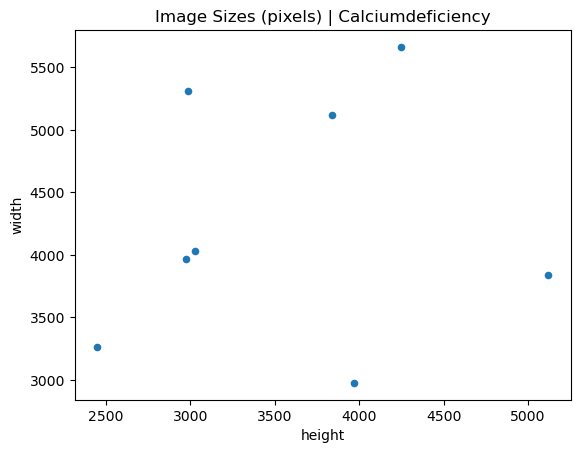

In [10]:
directories = {
               'leaf_spot': 'Dataset_Strawberry_Leaf_Disease/leaf_spot/', 
               'healthy': 'Dataset_Strawberry_Leaf_Disease/healthy/', 
               'Calciumdeficiency': 'Dataset_Strawberry_Leaf_Disease/Calciumdeficiency/'
              }

def get_dims(file):
    
    '''Returns dimensions of an RBG image'''
    
    im = Image.open(file)
    arr = np.array(im)
    h,w,d = arr.shape
    return h,w

for n,d in directories.items(): 
    filepath = d
    filelist = [filepath + f for f in os.listdir(filepath)]
    dimsbag = bag.from_sequence(filelist).map(get_dims)
    with diagnostics.ProgressBar():
        dims = dimsbag.compute()
        
    dim_df = pd.DataFrame(dims, columns=['height', 'width'])
    sizes = dim_df.groupby(['height', 'width']).size().reset_index().rename(columns={0:'count'})
    sizes.plot.scatter(x='height', y='width');
    plt.title('Image Sizes (pixels) | {}'.format(n))

# Splitting Images to Train/ Test Directories

In [11]:
#grab image names for each type
imgs_leafspot = [file for file in os.listdir(leafspot_dir)]
imgs_healthy = [file for file in os.listdir(healthy_dir)]
imgs_Calciumdeficiency = [file for file in os.listdir(Calciumdeficiency_dir)]

In [12]:
new_dir = 'split/'

In [13]:
#Check to ensure all images are included
print('# imgs_leafspot: ', len(imgs_leafspot))
print('# imgs_healthy: ', len(imgs_healthy))
print('# imgs_Calciumdeficiency: ', len(imgs_Calciumdeficiency))

# imgs_leafspot:  615
# imgs_healthy:  626
# imgs_Calciumdeficiency:  805


In [14]:
#os.mkdir(new_dir)

#create variables for new split directories for train/ test
train_folder = os.path.join(new_dir, 'train')
train_leafspot = os.path.join(train_folder, 'leaf_spot')
train_healthy = os.path.join(train_folder, 'healthy')
train_Calciumdeficiency = os.path.join(train_folder, 'Calciumdeficiency')
train_angular = os.path.join(train_folder, 'angular_leafspot')

test_folder = os.path.join(new_dir, 'test')
test_leafspot = os.path.join(test_folder, 'leaf_spot')
test_healthy = os.path.join(test_folder, 'healthy')
test_Calciumdeficiency = os.path.join(test_folder, 'Calciumdeficiency')

In [15]:
#create directories for splits
#os.mkdir(train_folder)
#os.mkdir(train_leafspot)
#os.mkdir(train_healthy)
#os.mkdir(train_Calciumdeficiency)

#os.mkdir(test_folder)
#os.mkdir(test_leafspot)
#os.mkdir(test_healthy)
#os.mkdir(test_Calciumdeficiency)

In [16]:
#use a 74/13/13 split for train/ test 
print('Number of images to test:')
print('# imgs_leafspot: ', round(len(imgs_leafspot)*.13))
print('# imgs_healthy: ', round(len(imgs_healthy)*.13))
print('# imgs_Calciumdeficiency: ', round(len(imgs_Calciumdeficiency)*.13))

Number of images to test:
# imgs_leafspot:  80
# imgs_healthy:  81
# imgs_Calciumdeficiency:  105


In [19]:
#imgs = imgs_leafspot[80:]
#for img in imgs:
#    origin = os.path.join(leafspot_dir, img)
#    destination = os.path.join(train_leafspot, img)
#    shutil.copyfile(origin, destination)
    
#imgs = imgs_healthy[81:]
#for img in imgs:
#    origin = os.path.join(healthy_dir, img)
#    destination = os.path.join(train_healthy, img)
#    shutil.copyfile(origin, destination)
    
#imgs = imgs_Calciumdeficiency[105:]
#for img in imgs:
#    origin = os.path.join(Calciumdeficiency_dir, img)
#    destination = os.path.join(train_Calciumdeficiency, img)
#    shutil.copyfile(origin, destination)

In [20]:
#imgs = imgs_leafspot[:80]
#for img in imgs:
#    origin = os.path.join(leafspot_dir, img)
#    destination = os.path.join(test_leafspot, img)
#    shutil.copyfile(origin, destination)
    
#imgs = imgs_healthy[:90]
#for img in imgs:
#    origin = os.path.join(healthy_dir, img)
##    destination = os.path.join(test_healthy, img)
    shutil.copyfile(origin, destination)
    
#imgs = imgs_Calciumdeficiency[:105]
#for img in imgs:
#    origin = os.path.join(Calciumdeficiency_dir, img)
#    destination = os.path.join(test_Calciumdeficiency, img)
#    shutil.copyfile(origin, destination)

# Applying Data Augmentation

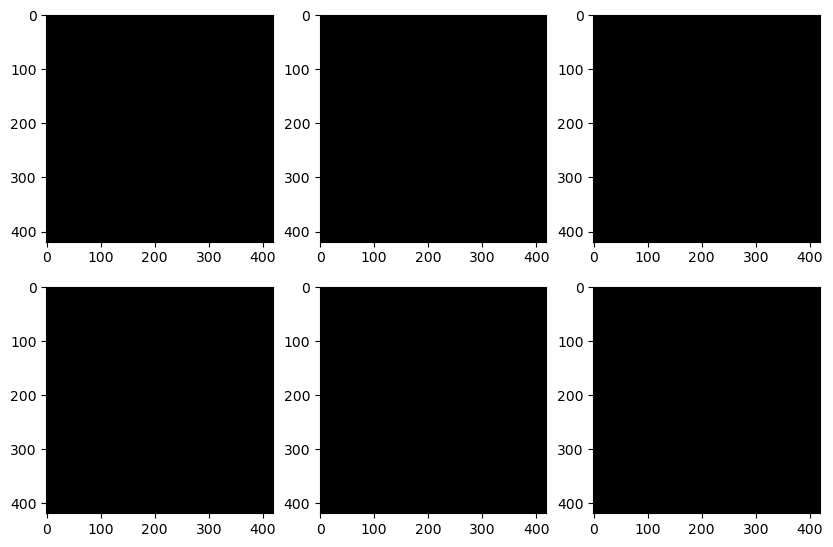

In [38]:
img = load_img('split/train/leaf_spot/leaf_spot214.jpg')
data = img_to_array(img)
samples = np.expand_dims(data, 0)

datagen = ImageDataGenerator(rescale = 1./255,
            horizontal_flip = True,
            vertical_flip = True,
            rotation_range=90,
            fill_mode='nearest',
            brightness_range=[0.4,1.5],
            validation_split = 0.2)
it = datagen.flow(samples, batch_size=1)

fig=plt.gcf()
fig.set_size_inches(ncols * 2, nrows * 2)
for i in range(6):
    plt.subplot(330 + 1 + i)
    batch = it.next()
    image = batch[0].astype('uint8')
    plt.imshow(image)
plt.show()

In [32]:
classes = ['leafspot','healthy','Calciumdeficiency']
batch_size = 128

In [33]:
# Rescaling images by 1./255
# Splitting data into training and validation sets
# Performing data augmentation on training images
train_datagen = ImageDataGenerator(
            rescale = 1./255,
            horizontal_flip = True,
            vertical_flip = True,
            rotation_range=90,
            fill_mode='nearest',
            brightness_range=[0.4,1.5],
            validation_split = 0.2
        )

train_generator = train_datagen.flow_from_directory(
        directory='./split/train',
        target_size=(200, 200),
        batch_size=batch_size,
        classes = classes,
        class_mode='categorical',
        subset='training')

Found 999 images belonging to 3 classes.


In [34]:
validation_generator = validation_datagen.flow_from_directory(
        directory='./split/train',
        target_size=(200, 200),
        batch_size=batch_size,
        classes = classes,
        class_mode='categorical',
        subset='validation')

Found 249 images belonging to 3 classes.


In [35]:
train_images, train_labels = next(train_generator)